# OpenFOAM projection integrator

This program calculates the path integral of a field (ie rho) along one of the principal axes.
It uses point-interpolated data exported from Paraview 5.9
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 23/11/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [10]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import glob, os, tqdm
import scipy.io, scipy.spatial, scipy.interpolate, scipy.ndimage
from joblib import Parallel, delayed
%matplotlib notebook

## Load Paraview/OpenFOAM isosurface data

In [334]:
directory = '/Users/dduke/Desktop/PMDI-papers-data/Validation/isosurface/'
description_string = 'HFA-134a solution 15%w/w ethanol'

In [208]:
# Load OF data
print('reading file...')
ofdata = np.genfromtxt(directory+'threshold_yMean99_134a15pcEtOH.csv',delimiter=',',names=True,\
                       usecols=('Points0','Points1','Points2','rhoMean'))
print('Read %i records.' % (len(ofdata)))

reading file...
Read 5365256 records.


In [209]:
# Select the scalar field to interpolate
scalarField = ofdata['rhoMean'] #*(1-ofdata['yMean']) # kg/m^3 = ug/mm^3

scalarFieldUnits='[kg/m$^3$]'
integratedUnits='[$\mu g / mm^2$]'

In [210]:
# Determine the axis values where we will cut slices. 
# By default we cut slices in 'z' and integrate in 'x'
x='Points0'; y='Points2'; z = 'Points1'

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_13374/2142344201.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(8,8))


<IPython.core.display.Javascript object>


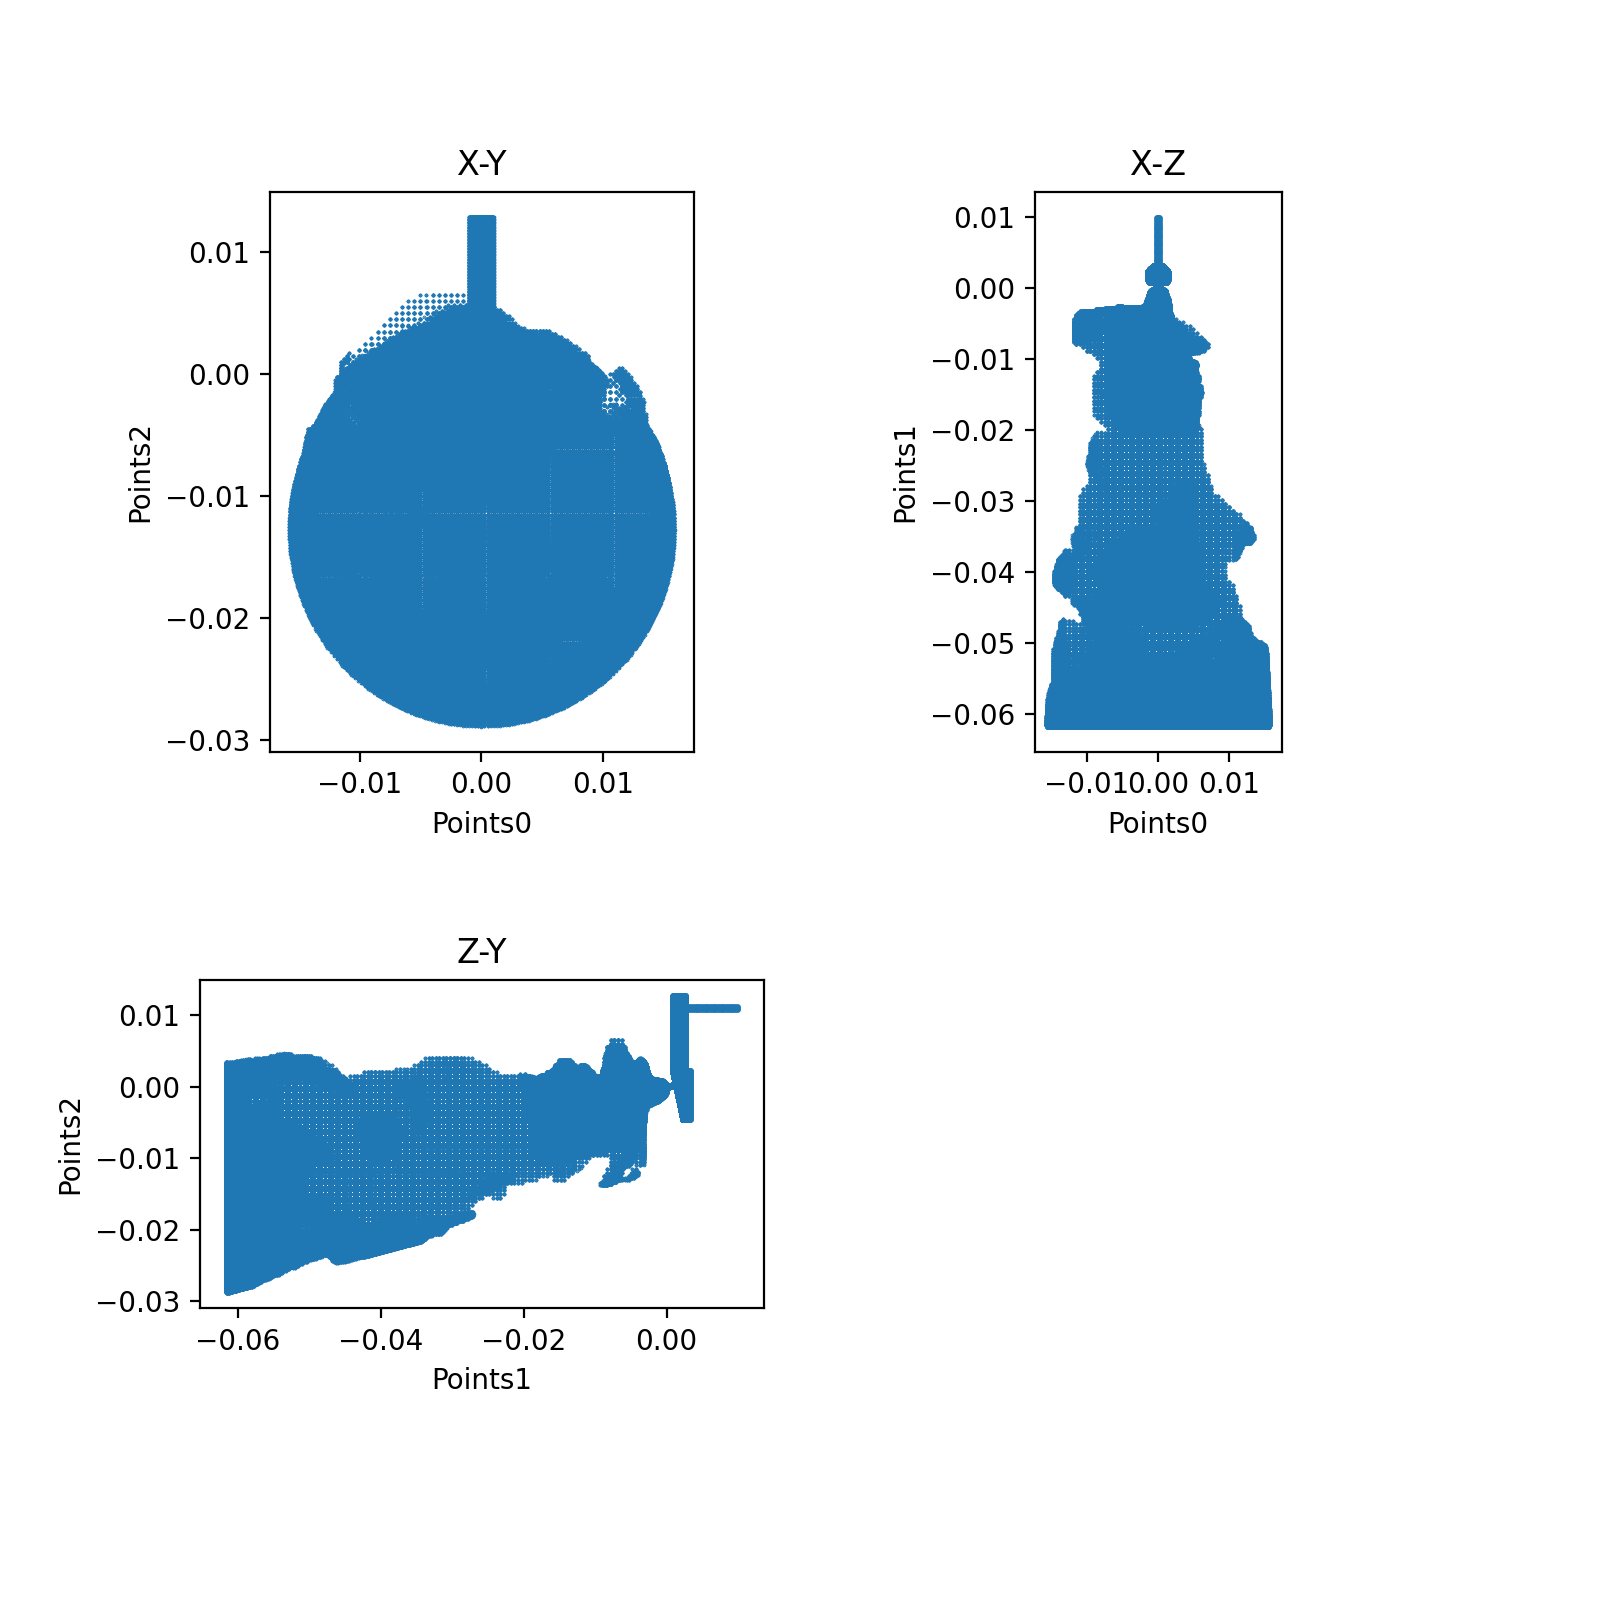

In [211]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(221)
ax.set_aspect('equal')
plt.scatter(ofdata[x],ofdata[y],marker='.',s=.5)
plt.xlabel(x); plt.ylabel(y); plt.title('X-Y')

ax=fig.add_subplot(222)
ax.set_aspect('equal')
plt.scatter(ofdata[x],ofdata[z],marker='.',s=.5)
plt.xlabel(x); plt.ylabel(z); plt.title('X-Z')

ax=fig.add_subplot(223)
ax.set_aspect('equal')
plt.scatter(ofdata[z],ofdata[y],marker='.',s=.5)
plt.xlabel(z); plt.ylabel(y); plt.title('Z-Y');

## Load X-ray scattering/radiography data for comparison

In [229]:
MIN_Z_MATCHING = 0.45
MAX_Z_MATCHING = 100.0 # maximum Z plane position to allow

# Load X-ray data....
import h5py
directory='/Users/dduke/Desktop/PMDI-papers-data/2019_12_APS_PMDI/DUKE Fluorescence 2019/plot_data_removedVapour/'
with h5py.File(directory+'TnB 1-hole, P134a + 15% ethanol.hdf5','r') as H:
    xray_profiles={}
    xray_z=[]
    for g in [k for k in H.keys() if 'mm' in k]:
        zval=float(g.split('=')[1].split(' ')[0])
        
        if((zval<=MAX_Z_MATCHING) and (zval>=MIN_Z_MATCHING)): # FILTER Z POSITIONS
            
            print(g)
            xray_profiles[g] = (zval,H[g+'/Time average/y'][...],\
                                H[g+'/Time average/time average projected mass'][...],\
                                H[g+'/Time average/time average error bar'][...])

            xray_z.append(zval)

xray_z=np.array(xray_z)

X=0.477 mm
X=1.500 mm
X=10.000 mm
X=15.000 mm
X=2.500 mm
X=5.000 mm
X=7.500 mm


## Interpolate the OF data at planes which match X-ray data.

In [239]:
# Use the Z axis for interpolation. Find suitable Z values.

# Use the X-ray values literally
zp=(-xray_z[:])*1e-3

# Take a range of slices near the X-ray values
zp = np.hstack([[(offset-z_)*1e-3 for offset in np.arange(-1,1.1,0.1) ] for z_ in xray_z])



print(z,ofdata[z].min(),ofdata[z].max())
print('Interpolate at:', np.round(zp*1e3,3),'mm (%i pts)' % len(zp))

Points1 -0.0617170259 0.00999999978
Interpolate at: [ -1.477  -1.377  -1.277  -1.177  -1.077  -0.977  -0.877  -0.777  -0.677
  -0.577  -0.477  -0.377  -0.277  -0.177  -0.077   0.023   0.123   0.223
   0.323   0.423   0.523  -2.5    -2.4    -2.3    -2.2    -2.1    -2.
  -1.9    -1.8    -1.7    -1.6    -1.5    -1.4    -1.3    -1.2    -1.1
  -1.     -0.9    -0.8    -0.7    -0.6    -0.5   -11.    -10.9   -10.8
 -10.7   -10.6   -10.5   -10.4   -10.3   -10.2   -10.1   -10.     -9.9
  -9.8    -9.7    -9.6    -9.5    -9.4    -9.3    -9.2    -9.1    -9.
 -16.    -15.9   -15.8   -15.7   -15.6   -15.5   -15.4   -15.3   -15.2
 -15.1   -15.    -14.9   -14.8   -14.7   -14.6   -14.5   -14.4   -14.3
 -14.2   -14.1   -14.     -3.5    -3.4    -3.3    -3.2    -3.1    -3.
  -2.9    -2.8    -2.7    -2.6    -2.5    -2.4    -2.3    -2.2    -2.1
  -2.     -1.9    -1.8    -1.7    -1.6    -1.5    -6.     -5.9    -5.8
  -5.7    -5.6    -5.5    -5.4    -5.3    -5.2    -5.1    -5.     -4.9
  -4.8    -4.7    -4.6  

In [240]:
def sliceInterpolatorFun(z_, showFigure=True, interp_res=256):

    # Get smallest viable subset of data that is nearby the point for speedy interpolation
    for tol in np.logspace(-4,0,6):
        idx = np.where(np.abs(ofdata[z]-z_)<tol)[0]
        if(len(idx)>=20000): break

    # Develop a suitable grid in the X & Y axes for interpolating onto
    xp = np.linspace(ofdata[x][idx].min(), ofdata[x][idx].max(), interp_res+1) # unequal no pts to ensure no axis mix ups
    yp = np.linspace(ofdata[y][idx].min(), ofdata[y][idx].max(), interp_res)
    Xp, Yp = np.meshgrid(xp, yp)
    
    if np.any(~np.isnan(scalarField[idx])):
    
        # Generate a triangulation for this subset of data.
        print("Triangulating at z=%.3f\u00B1%.3f mm using %i points (%.1f%%)" % (z_*1e3,tol*1e3,len(idx),\
                                                                                 100*len(idx)/len(scalarField)))

        # Delaunay triangulation
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html
        tri = scipy.spatial.Delaunay(np.transpose(np.vstack((ofdata[x][idx], ofdata[y][idx], ofdata[z][idx]))),\
                                     furthest_site=False, incremental=False, qhull_options=None)

        # Linear N-dimensional interpolation
        #https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.LinearNDInterpolator.html            
        fInt = scipy.interpolate.LinearNDInterpolator(tri, scalarField[idx], fill_value=np.nan, rescale=False)

        interpolated = fInt(Xp,Yp,z_)
        
    else: 
        interpolated=np.zeros_like(Xp)
        interpolated[...]=np.nan
        
    
    # Make figure?
    if showFigure:
        fig=plt.figure()
        ax=fig.add_subplot(111)
        ax.set_aspect('equal')
        p_=ax.pcolormesh(xp*1e3,yp*1e3,interpolated,cmap='jet')
        plt.colorbar(p_)
        plt.xlabel(x+' [mm]')
        plt.ylabel(y+' [mm]')
        plt.title('%s, Z = %f' % (scalarFieldUnits,z_))

    # X-integral
    filteredScalarField = np.nan_to_num(interpolated)
    filteredScalarField[filteredScalarField<0]=0.
    
    integral = np.trapz(filteredScalarField,x=xp,axis=1)
    
    return (yp,integral,xp,interpolated,len(idx))
    

## Perform interpolation onto slice
Alternatively, load data from saved file from a previous run, as this can take an hour or so.

In [241]:
# Loop over Z values
#integrals=[ sliceInterpolatorFun(z_, False) for z_ in zp ]
integrals = Parallel(n_jobs=6,verbose=20)(delayed(sliceInterpolatorFun)(z_, False) for z_ in zp)

#Check n points in interp.
for i in range(len(integrals)): print('z=%.3f mm' % (zp[i]*1e3),integrals[i][4],'pts')

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   32.6s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:   40.3s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:   41.7s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:   44.5s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:   51.5s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done  15 tasks      | elapsed:  1.2min
[Parallel(

Triangulating at z=-1.477±0.100 mm using 55009 points (1.0%)
Triangulating at z=-0.877±0.100 mm using 87833 points (1.6%)
Triangulating at z=-0.277±0.100 mm using 81882 points (1.5%)
Triangulating at z=0.323±0.631 mm using 158122 points (2.9%)


/usr/local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=6)]: Done  19 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:  1.4min


Triangulating at z=-1.277±0.100 mm using 82478 points (1.5%)
Triangulating at z=-0.577±0.100 mm using 88142 points (1.6%)
Triangulating at z=0.023±0.100 mm using 32449 points (0.6%)
Triangulating at z=0.223±0.631 mm using 191056 points (3.6%)


[Parallel(n_jobs=6)]: Done  21 tasks      | elapsed:  1.5min


Triangulating at z=-1.377±0.100 mm using 77959 points (1.5%)
Triangulating at z=-0.677±0.100 mm using 87983 points (1.6%)
Triangulating at z=0.123±0.631 mm using 230956 points (4.3%)


[Parallel(n_jobs=6)]: Done  22 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  23 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  26 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done  27 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  30 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  31 tasks      | elapsed:  1.8min


Triangulating at z=-2.200±0.631 mm using 70445 points (1.3%)
Triangulating at z=-1.800±0.631 mm using 184721 points (3.4%)


[Parallel(n_jobs=6)]: Done  32 tasks      | elapsed:  1.9min


Triangulating at z=-0.977±0.100 mm using 88110 points (1.6%)
Triangulating at z=-0.777±0.100 mm using 81467 points (1.5%)
Triangulating at z=-0.177±0.100 mm using 81096 points (1.5%)
Triangulating at z=-2.500±0.631 mm using 90570 points (1.7%)
Triangulating at z=-1.700±0.631 mm using 219672 points (4.1%)


[Parallel(n_jobs=6)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=6)]: Done  35 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done  36 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done  37 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  39 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Done  41 tasks      | elapsed:  3.0min
[Parallel(n_jobs=6)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=6)]: Done  43 tasks      | elapsed:  5.9min
[Parallel(n_jobs=6)]: Done  44 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done  45 tasks      | elapsed:  7.5min


Triangulating at z=-1.177±0.100 mm using 89426 points (1.7%)
Triangulating at z=-0.477±0.100 mm using 86589 points (1.6%)
Triangulating at z=-0.077±0.100 mm using 65114 points (1.2%)
Triangulating at z=0.523±0.631 mm using 97066 points (1.8%)
Triangulating at z=-2.400±0.631 mm using 79655 points (1.5%)
Triangulating at z=-2.000±0.631 mm using 107128 points (2.0%)
Triangulating at z=-1.400±0.100 mm using 69563 points (1.3%)
Triangulating at z=-11.000±0.100 mm using 62802 points (1.2%)


[Parallel(n_jobs=6)]: Done  46 tasks      | elapsed:  8.3min
[Parallel(n_jobs=6)]: Done  47 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done  48 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done  50 tasks      | elapsed: 11.5min
[Parallel(n_jobs=6)]: Done  51 tasks      | elapsed: 11.6min
[Parallel(n_jobs=6)]: Done  52 tasks      | elapsed: 13.5min
[Parallel(n_jobs=6)]: Done  53 tasks      | elapsed: 13.8min
[Parallel(n_jobs=6)]: Done  54 tasks      | elapsed: 15.2min
[Parallel(n_jobs=6)]: Done  55 tasks      | elapsed: 15.6min
[Parallel(n_jobs=6)]: Done  56 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done  57 tasks      | elapsed: 16.3min
[Parallel(n_jobs=6)]: Done  58 tasks      | elapsed: 17.1min
[Parallel(n_jobs=6)]: Done  59 tasks      | elapsed: 17.8min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 18.1min
[Parallel(n_jobs=6)]: Done  61 tasks      | elapsed: 18.2min
[Parallel(n_jobs=6)]: Do

Triangulating at z=-0.900±0.100 mm using 81745 points (1.5%)
Triangulating at z=-0.600±0.100 mm using 87077 points (1.6%)
Triangulating at z=-10.800±0.100 mm using 61139 points (1.1%)
Triangulating at z=-10.000±0.100 mm using 52303 points (1.0%)
Triangulating at z=-9.600±0.100 mm using 50315 points (0.9%)
Triangulating at z=-9.400±0.100 mm using 65236 points (1.2%)
Triangulating at z=-15.400±0.100 mm using 85802 points (1.6%)
Triangulating at z=-3.500±0.100 mm using 26667 points (0.5%)
Triangulating at z=-3.400±0.100 mm using 25876 points (0.5%)
Triangulating at z=-3.300±0.100 mm using 25716 points (0.5%)
Triangulating at z=-3.200±0.100 mm using 32939 points (0.6%)
Triangulating at z=-3.100±0.100 mm using 23422 points (0.4%)
Triangulating at z=-3.000±0.100 mm using 22420 points (0.4%)
Triangulating at z=-2.700±0.100 mm using 23475 points (0.4%)
Triangulating at z=-2.600±0.631 mm using 97061 points (1.8%)


[Parallel(n_jobs=6)]: Done  90 tasks      | elapsed: 35.3min
[Parallel(n_jobs=6)]: Done  91 tasks      | elapsed: 35.4min
[Parallel(n_jobs=6)]: Done  92 tasks      | elapsed: 35.5min
[Parallel(n_jobs=6)]: Done  93 tasks      | elapsed: 35.6min
[Parallel(n_jobs=6)]: Done  94 tasks      | elapsed: 35.6min
[Parallel(n_jobs=6)]: Done  95 tasks      | elapsed: 35.7min
[Parallel(n_jobs=6)]: Done  96 tasks      | elapsed: 35.7min


Triangulating at z=-1.077±0.100 mm using 90081 points (1.7%)
Triangulating at z=-0.377±0.100 mm using 87705 points (1.6%)
Triangulating at z=0.423±0.631 mm using 122836 points (2.3%)
Triangulating at z=-2.300±0.631 mm using 77901 points (1.5%)
Triangulating at z=-1.200±0.100 mm using 90472 points (1.7%)
Triangulating at z=-10.500±0.100 mm using 59037 points (1.1%)
Triangulating at z=-10.300±0.100 mm using 56085 points (1.0%)
Triangulating at z=-9.700±0.100 mm using 50617 points (0.9%)
Triangulating at z=-9.500±0.100 mm using 50079 points (0.9%)
Triangulating at z=-9.200±0.100 mm using 50531 points (0.9%)
Triangulating at z=-16.000±0.100 mm using 65594 points (1.2%)
Triangulating at z=-15.500±0.100 mm using 66023 points (1.2%)
Triangulating at z=-15.300±0.100 mm using 64910 points (1.2%)
Triangulating at z=-14.600±0.100 mm using 64724 points (1.2%)
Triangulating at z=-14.300±0.100 mm using 64065 points (1.2%)
Triangulating at z=-2.000±0.631 mm using 107128 points (2.0%)


[Parallel(n_jobs=6)]: Done  97 tasks      | elapsed: 35.8min
[Parallel(n_jobs=6)]: Done  98 tasks      | elapsed: 35.9min


Triangulating at z=-10.200±0.100 mm using 54835 points (1.0%)
Triangulating at z=-9.900±0.100 mm using 67380 points (1.3%)
Triangulating at z=-15.700±0.100 mm using 86946 points (1.6%)
Triangulating at z=-14.400±0.100 mm using 63852 points (1.2%)
Triangulating at z=-14.000±0.100 mm using 65355 points (1.2%)
Triangulating at z=-2.200±0.631 mm using 70445 points (1.3%)
Triangulating at z=-2.100±0.631 mm using 79506 points (1.5%)
Triangulating at z=-1.900±0.631 mm using 139159 points (2.6%)


[Parallel(n_jobs=6)]: Done  99 tasks      | elapsed: 36.0min
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed: 36.1min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 36.1min


Triangulating at z=-2.500±0.631 mm using 90570 points (1.7%)
Triangulating at z=-2.400±0.631 mm using 79655 points (1.5%)
Triangulating at z=-2.300±0.631 mm using 77901 points (1.5%)
Triangulating at z=-1.700±0.631 mm using 219672 points (4.1%)


[Parallel(n_jobs=6)]: Done 102 tasks      | elapsed: 36.2min
[Parallel(n_jobs=6)]: Done 103 tasks      | elapsed: 36.5min
[Parallel(n_jobs=6)]: Done 104 tasks      | elapsed: 36.9min
[Parallel(n_jobs=6)]: Done 105 tasks      | elapsed: 36.9min
[Parallel(n_jobs=6)]: Done 106 tasks      | elapsed: 37.1min


Triangulating at z=-2.100±0.631 mm using 79506 points (1.5%)
Triangulating at z=-1.600±0.100 mm using 22203 points (0.4%)
Triangulating at z=-1.500±0.100 mm using 45439 points (0.8%)
Triangulating at z=-1.100±0.100 mm using 88511 points (1.6%)
Triangulating at z=-0.700±0.100 mm using 88797 points (1.7%)
Triangulating at z=-10.600±0.100 mm using 60342 points (1.1%)
Triangulating at z=-10.400±0.100 mm using 75641 points (1.4%)
Triangulating at z=-9.000±0.100 mm using 50763 points (0.9%)
Triangulating at z=-15.800±0.100 mm using 65112 points (1.2%)
Triangulating at z=-15.200±0.100 mm using 65420 points (1.2%)
Triangulating at z=-14.900±0.100 mm using 84139 points (1.6%)


[Parallel(n_jobs=6)]: Done 107 tasks      | elapsed: 37.6min
[Parallel(n_jobs=6)]: Done 108 tasks      | elapsed: 37.6min
[Parallel(n_jobs=6)]: Done 109 tasks      | elapsed: 37.9min
[Parallel(n_jobs=6)]: Done 110 tasks      | elapsed: 38.5min
[Parallel(n_jobs=6)]: Done 111 tasks      | elapsed: 38.6min
[Parallel(n_jobs=6)]: Done 112 tasks      | elapsed: 38.7min
[Parallel(n_jobs=6)]: Done 113 tasks      | elapsed: 39.8min
[Parallel(n_jobs=6)]: Done 114 tasks      | elapsed: 40.0min
[Parallel(n_jobs=6)]: Done 115 tasks      | elapsed: 40.2min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 40.3min
[Parallel(n_jobs=6)]: Done 117 tasks      | elapsed: 40.5min
[Parallel(n_jobs=6)]: Done 118 tasks      | elapsed: 40.5min
[Parallel(n_jobs=6)]: Done 119 tasks      | elapsed: 40.6min
[Parallel(n_jobs=6)]: Done 120 tasks      | elapsed: 40.9min
[Parallel(n_jobs=6)]: Done 121 tasks      | elapsed: 41.0min
[Parallel(n_jobs=6)]: Done 122 tasks      | elapsed: 41.1min
[Parallel(n_jobs=6)]: Do

Triangulating at z=-1.000±0.100 mm using 88148 points (1.6%)
Triangulating at z=-0.800±0.100 mm using 88434 points (1.6%)
Triangulating at z=-10.700±0.100 mm using 61523 points (1.1%)
Triangulating at z=-10.100±0.100 mm using 53492 points (1.0%)
Triangulating at z=-9.800±0.100 mm using 50288 points (0.9%)
Triangulating at z=-9.100±0.100 mm using 50513 points (0.9%)
Triangulating at z=-15.600±0.100 mm using 66114 points (1.2%)
Triangulating at z=-15.000±0.100 mm using 64772 points (1.2%)
Triangulating at z=-14.700±0.100 mm using 64543 points (1.2%)
Triangulating at z=-14.200±0.100 mm using 85561 points (1.6%)


[Parallel(n_jobs=6)]: Done 124 tasks      | elapsed: 41.2min


Triangulating at z=-1.600±0.100 mm using 22203 points (0.4%)
Triangulating at z=-1.500±0.100 mm using 45439 points (0.8%)
Triangulating at z=-5.800±0.100 mm using 41802 points (0.8%)
Triangulating at z=-5.600±0.100 mm using 40197 points (0.7%)
Triangulating at z=-5.200±0.100 mm using 48498 points (0.9%)
Triangulating at z=-4.300±0.100 mm using 27058 points (0.5%)


[Parallel(n_jobs=6)]: Done 125 tasks      | elapsed: 41.3min
[Parallel(n_jobs=6)]: Done 126 tasks      | elapsed: 42.1min
[Parallel(n_jobs=6)]: Done 127 tasks      | elapsed: 42.3min
[Parallel(n_jobs=6)]: Done 128 tasks      | elapsed: 42.8min
[Parallel(n_jobs=6)]: Done 129 tasks      | elapsed: 43.1min
[Parallel(n_jobs=6)]: Done 130 tasks      | elapsed: 43.4min
[Parallel(n_jobs=6)]: Done 131 tasks      | elapsed: 44.2min
[Parallel(n_jobs=6)]: Done 132 tasks      | elapsed: 44.9min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 45.7min


Triangulating at z=-5.400±0.100 mm using 37054 points (0.7%)
Triangulating at z=-5.100±0.100 mm using 35830 points (0.7%)
Triangulating at z=-5.000±0.100 mm using 34460 points (0.6%)
Triangulating at z=-4.700±0.100 mm using 32457 points (0.6%)
Triangulating at z=-4.500±0.100 mm using 28190 points (0.5%)
Triangulating at z=-4.100±0.100 mm using 27492 points (0.5%)
Triangulating at z=-4.000±0.100 mm using 28446 points (0.5%)
Triangulating at z=-8.100±0.100 mm using 56741 points (1.1%)
Triangulating at z=-7.800±0.100 mm using 60067 points (1.1%)
Triangulating at z=-7.500±0.100 mm using 62314 points (1.2%)


[Parallel(n_jobs=6)]: Done 134 tasks      | elapsed: 46.5min
[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed: 46.9min
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed: 47.3min


Triangulating at z=-1.900±0.631 mm using 139159 points (2.6%)
Triangulating at z=-1.300±0.100 mm using 87939 points (1.6%)
Triangulating at z=-0.500±0.100 mm using 86762 points (1.6%)
Triangulating at z=-10.900±0.100 mm using 81152 points (1.5%)
Triangulating at z=-9.300±0.100 mm using 49478 points (0.9%)
Triangulating at z=-15.900±0.100 mm using 64950 points (1.2%)
Triangulating at z=-15.100±0.100 mm using 65196 points (1.2%)
Triangulating at z=-14.800±0.100 mm using 63715 points (1.2%)
Triangulating at z=-14.500±0.100 mm using 64759 points (1.2%)
Triangulating at z=-14.100±0.100 mm using 65256 points (1.2%)
Triangulating at z=-2.900±0.100 mm using 21558 points (0.4%)
Triangulating at z=-2.800±0.631 mm using 123817 points (2.3%)
Triangulating at z=-5.700±0.100 mm using 54552 points (1.0%)
Triangulating at z=-7.100±0.100 mm using 61269 points (1.1%)
Triangulating at z=-6.800±0.100 mm using 57262 points (1.1%)
Triangulating at z=-6.600±0.100 mm using 55477 points (1.0%)
Triangulating at

[Parallel(n_jobs=6)]: Done 144 out of 147 | elapsed: 52.2min remaining:  1.1min


z=-1.477 mm 55009 pts
z=-1.377 mm 77959 pts
z=-1.277 mm 82478 pts
z=-1.177 mm 89426 pts
z=-1.077 mm 90081 pts
z=-0.977 mm 88110 pts
z=-0.877 mm 87833 pts
z=-0.777 mm 81467 pts
z=-0.677 mm 87983 pts
z=-0.577 mm 88142 pts
z=-0.477 mm 86589 pts
z=-0.377 mm 87705 pts
z=-0.277 mm 81882 pts
z=-0.177 mm 81096 pts
z=-0.077 mm 65114 pts
z=0.023 mm 32449 pts
z=0.123 mm 230956 pts
z=0.223 mm 191056 pts
z=0.323 mm 158122 pts
z=0.423 mm 122836 pts
z=0.523 mm 97066 pts
z=-2.500 mm 90570 pts
z=-2.400 mm 79655 pts
z=-2.300 mm 77901 pts
z=-2.200 mm 70445 pts
z=-2.100 mm 79506 pts
z=-2.000 mm 107128 pts
z=-1.900 mm 139159 pts
z=-1.800 mm 184721 pts
z=-1.700 mm 219672 pts
z=-1.600 mm 22203 pts
z=-1.500 mm 45439 pts
z=-1.400 mm 69563 pts
z=-1.300 mm 87939 pts
z=-1.200 mm 90472 pts
z=-1.100 mm 88511 pts
z=-1.000 mm 88148 pts
z=-0.900 mm 81745 pts
z=-0.800 mm 88434 pts
z=-0.700 mm 88797 pts
z=-0.600 mm 87077 pts
z=-0.500 mm 86762 pts
z=-11.000 mm 62802 pts
z=-10.900 mm 81152 pts
z=-10.800 mm 61139 pts
z=-10

[Parallel(n_jobs=6)]: Done 147 out of 147 | elapsed: 54.6min finished


/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_13374/2966267646.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(10,10))


<IPython.core.display.Javascript object>


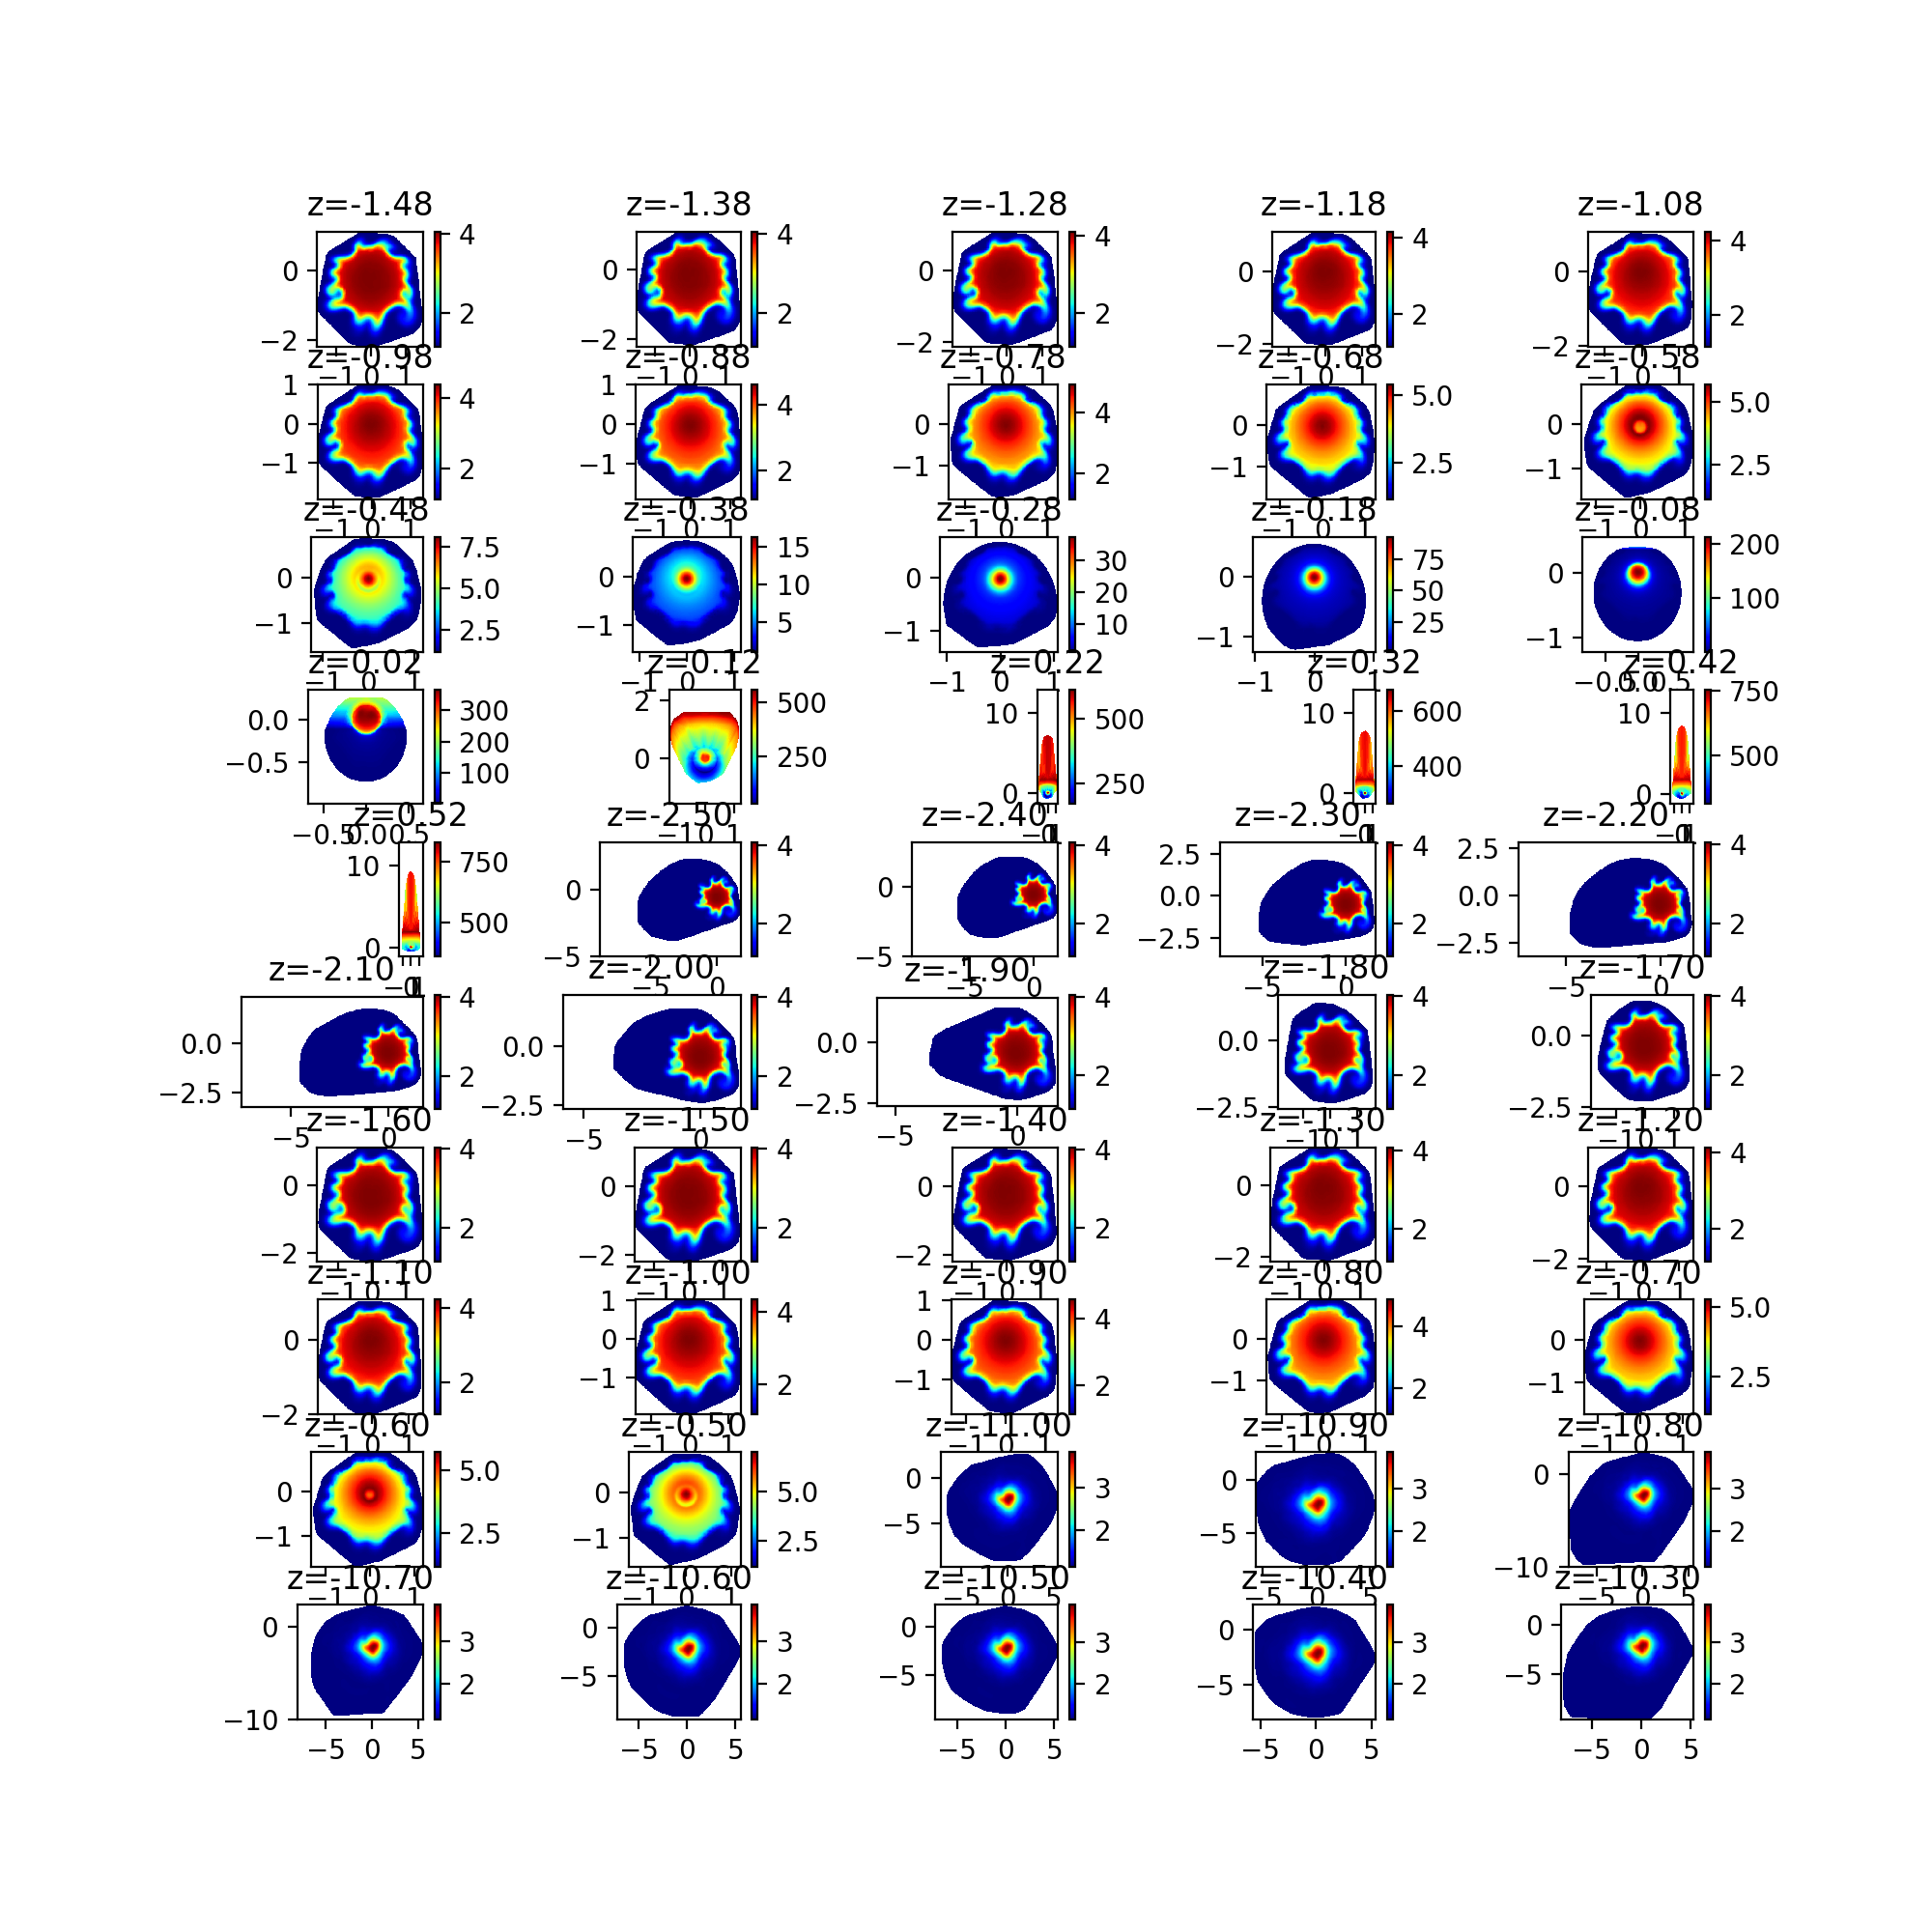

In [248]:
# Plot slices
fig=plt.figure(figsize=(10,10))
for i in range(len(integrals)):
    yp,integral,xp,interpolated,l = integrals[i]
    ax=fig.add_subplot(10,5,1+i)
    ax.set_aspect('equal')
    p_=ax.pcolormesh(xp*1e3,yp*1e3,interpolated,cmap='jet')
    plt.colorbar(p_)
    #plt.xlabel(x+' [mm]')
    #plt.ylabel(y+' [mm]')
    plt.title('z=%.2f' % (zp[i]*1e3))
    if i>=49:break
plt.subplots_adjust(hspace=.33,wspace=.4)

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_13374/2829056929.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure()


<IPython.core.display.Javascript object>


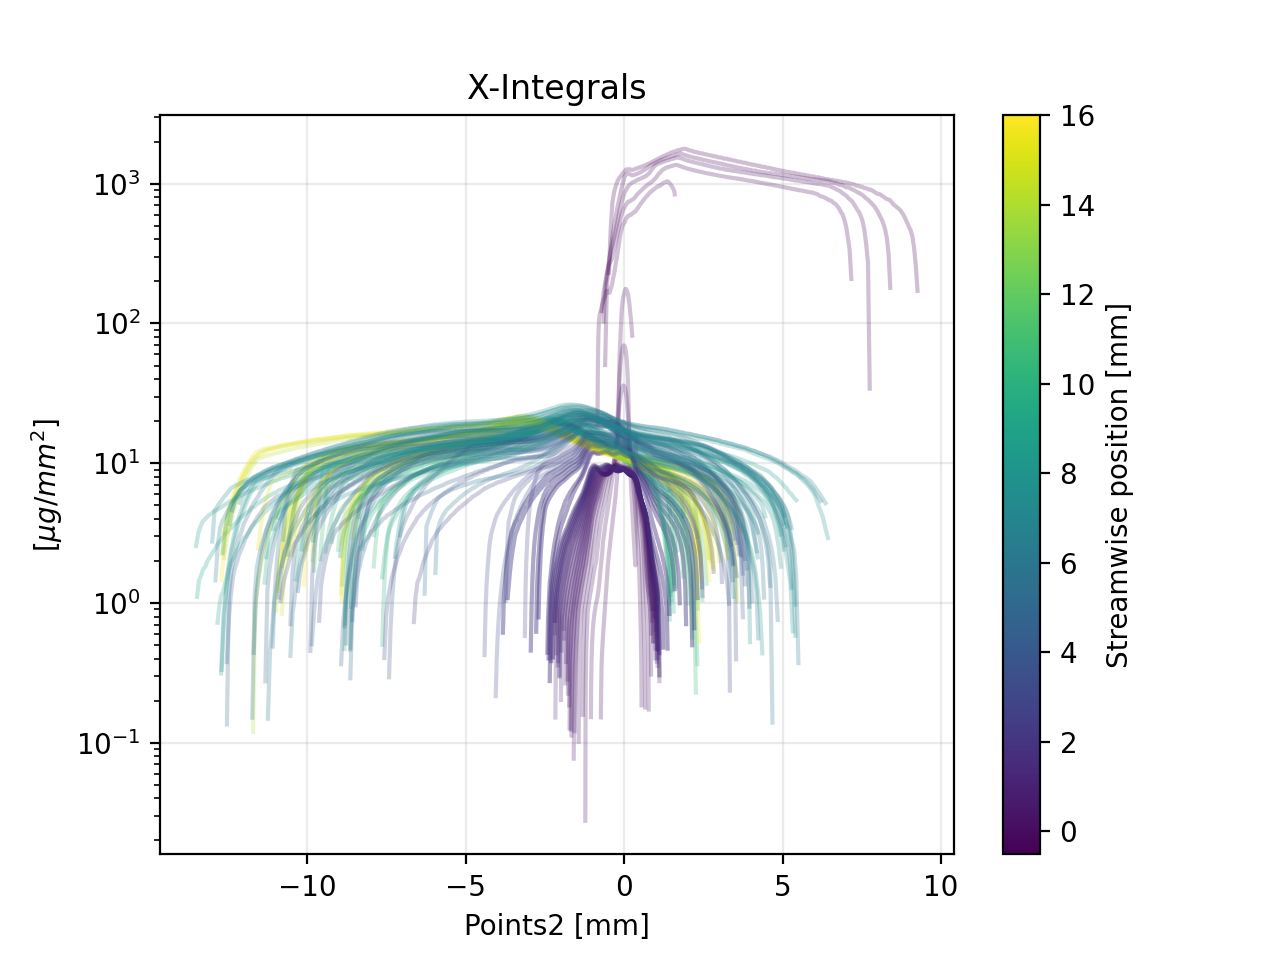

In [249]:
# Plot integrals

recenter=False

fig=plt.figure()
ax=fig.add_subplot(111)
cmap=plt.cm.viridis
dummy_cax = ax.scatter(-zp*1e3, -zp*1e3, c=-zp*1e3, cmap=cmap)
plt.cla()

ax.set_yscale('log')
plt.grid(alpha=.25)



for i in range(len(integrals)):
    
    if recenter:
        maxi = np.where(integrals[i][1] == np.nanmax(integrals[i][1]))[0][0]
        x0 = integrals[i][0][maxi]
    else:
        x0=0
        
    y_ = (integrals[i][0]-x0)*1e3
    x_ = integrals[i][1]*1e3
    
    x_[x_<=0]=np.nan
        
    ax.plot(y_, x_,label='Z = %.3f mm' % (zp[i]*1e3),alpha=.25,\
            c=cmap((zp.max()-zp[i])/(zp.max()-zp.min())))

plt.title('X-Integrals')
plt.xlabel('%s [mm]' % y)
plt.ylabel(integratedUnits)
cb=plt.colorbar(dummy_cax,ax=ax)
cb.set_label('Streamwise position [mm]')


In [251]:
# Save interpolated OF data to avoid needing to re-process.
import h5py
with h5py.File('threshold_yMean99_134a15pcEtOH.h5','w') as F:
    for i in range(len(integrals)):
        yp,integral,xp,interpolated,npts = integrals[i]
        grpName = 'Z=%f mm' % zp[i]
        if not grpName in F:
            G=F.create_group(grpName)
            G.create_dataset('yp',data=yp,compression='gzip')
            G.create_dataset('xp',data=xp,compression='gzip')
            G.create_dataset('integral',data=integral,compression='gzip')
            G.create_dataset('interpolated',data=interpolated,compression='gzip')
            G.attrs['npts']=npts
            G.attrs['z']=zp[i]
            print('Write',G.name)
        else:
            print('Skip',grpName)
            
print("Done")

Write /Z=-0.001477 mm
Write /Z=-0.001377 mm
Write /Z=-0.001277 mm
Write /Z=-0.001177 mm
Write /Z=-0.001077 mm
Write /Z=-0.000977 mm
Write /Z=-0.000877 mm
Write /Z=-0.000777 mm
Write /Z=-0.000677 mm
Write /Z=-0.000577 mm
Write /Z=-0.000477 mm
Write /Z=-0.000377 mm
Write /Z=-0.000277 mm
Write /Z=-0.000177 mm
Write /Z=-0.000077 mm
Write /Z=0.000023 mm
Write /Z=0.000123 mm
Write /Z=0.000223 mm
Write /Z=0.000323 mm
Write /Z=0.000423 mm
Write /Z=0.000523 mm
Write /Z=-0.002500 mm
Write /Z=-0.002400 mm
Write /Z=-0.002300 mm
Write /Z=-0.002200 mm
Write /Z=-0.002100 mm
Write /Z=-0.002000 mm
Write /Z=-0.001900 mm
Write /Z=-0.001800 mm
Write /Z=-0.001700 mm
Write /Z=-0.001600 mm
Write /Z=-0.001500 mm
Write /Z=-0.001400 mm
Write /Z=-0.001300 mm
Write /Z=-0.001200 mm
Write /Z=-0.001100 mm
Write /Z=-0.001000 mm
Write /Z=-0.000900 mm
Write /Z=-0.000800 mm
Write /Z=-0.000700 mm
Write /Z=-0.000600 mm
Write /Z=-0.000500 mm
Write /Z=-0.011000 mm
Write /Z=-0.010900 mm
Write /Z=-0.010800 mm
Write /Z=-0.0107

## Plot the OF and X-ray data together.

Use dots for Xray and lines for OF

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_13374/2220453540.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure()


<IPython.core.display.Javascript object>


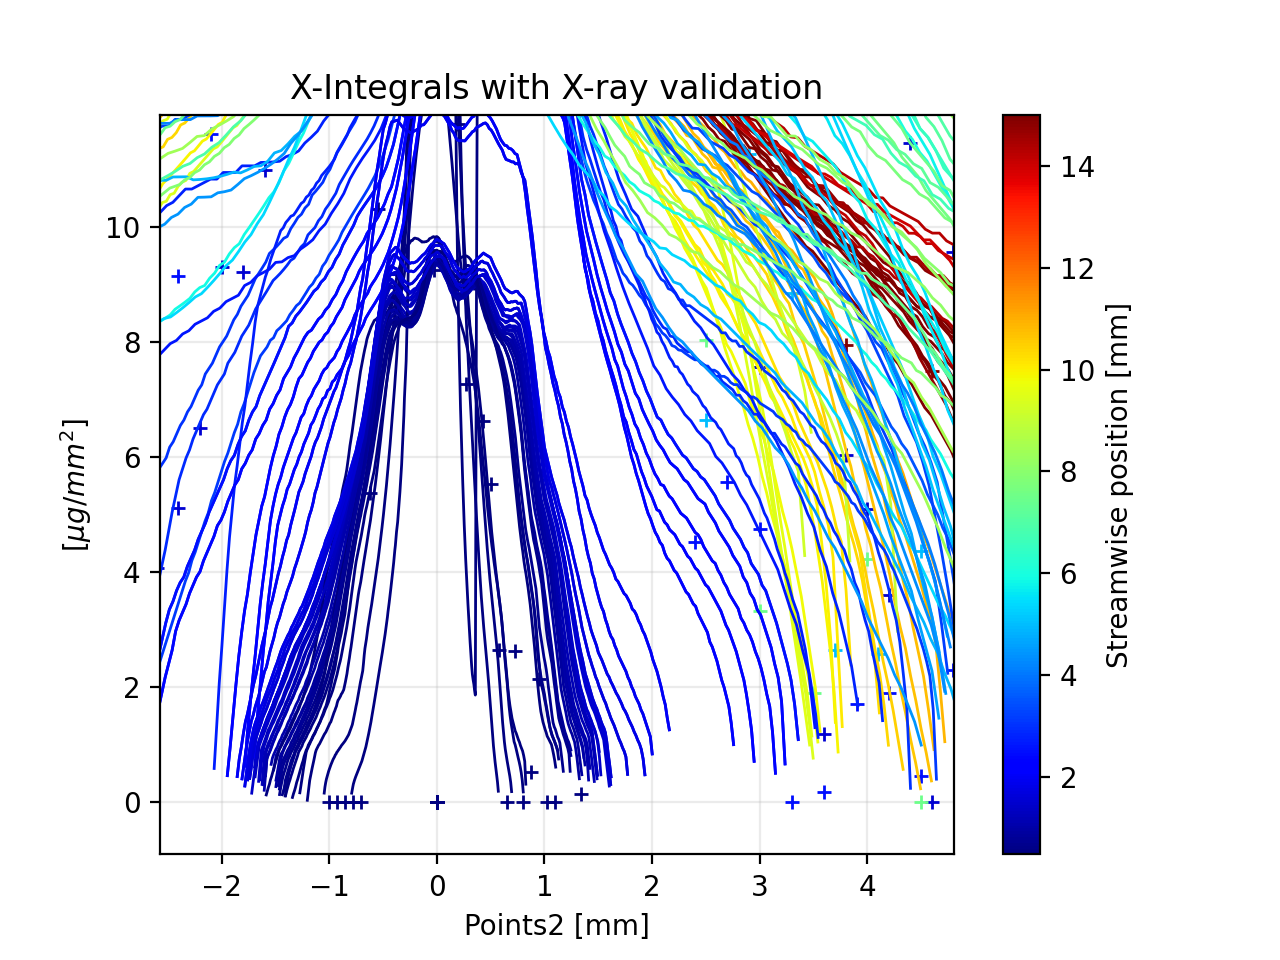

In [266]:
# Plot EVERYTHING

fig=plt.figure()
ax=fig.add_subplot(111)
cmap=plt.cm.jet
dummy_cax = ax.scatter(xray_z, xray_z, c=xray_z, cmap=cmap)
plt.cla()
#ax.set_yscale('log')
plt.grid(alpha=.25)

recenter=True

cmapfun = lambda x_: (x_-xray_z.min())/(xray_z.max()-xray_z.min())

for xray in xray_profiles.values():
    ax.plot(xray[1],xray[2]*(xray[2]>=0),lw=0,ls=None,marker='+',ms=5,c=cmap(cmapfun(xray[0])))
    
for i in range(len(integrals)):
    if recenter:
        maxi = np.where(integrals[i][1] == np.nanmax(integrals[i][1]))[0][0]
        x0 = integrals[i][0][maxi]
    else:
        x0=0  
    y_ = (integrals[i][0]-x0)*1e3
    x_ = integrals[i][1]*1e3
    x_[x_==0]=np.nan
    ax.plot(y_, x_, lw=1, c=cmap(cmapfun(-1e3*zp[i])))
    
plt.title('X-Integrals with X-ray validation')
plt.xlabel('%s [mm]' % y)
plt.ylabel(integratedUnits)
cb=plt.colorbar(dummy_cax,ax=ax)
cb.set_label('Streamwise position [mm]')


<IPython.core.display.Javascript object>


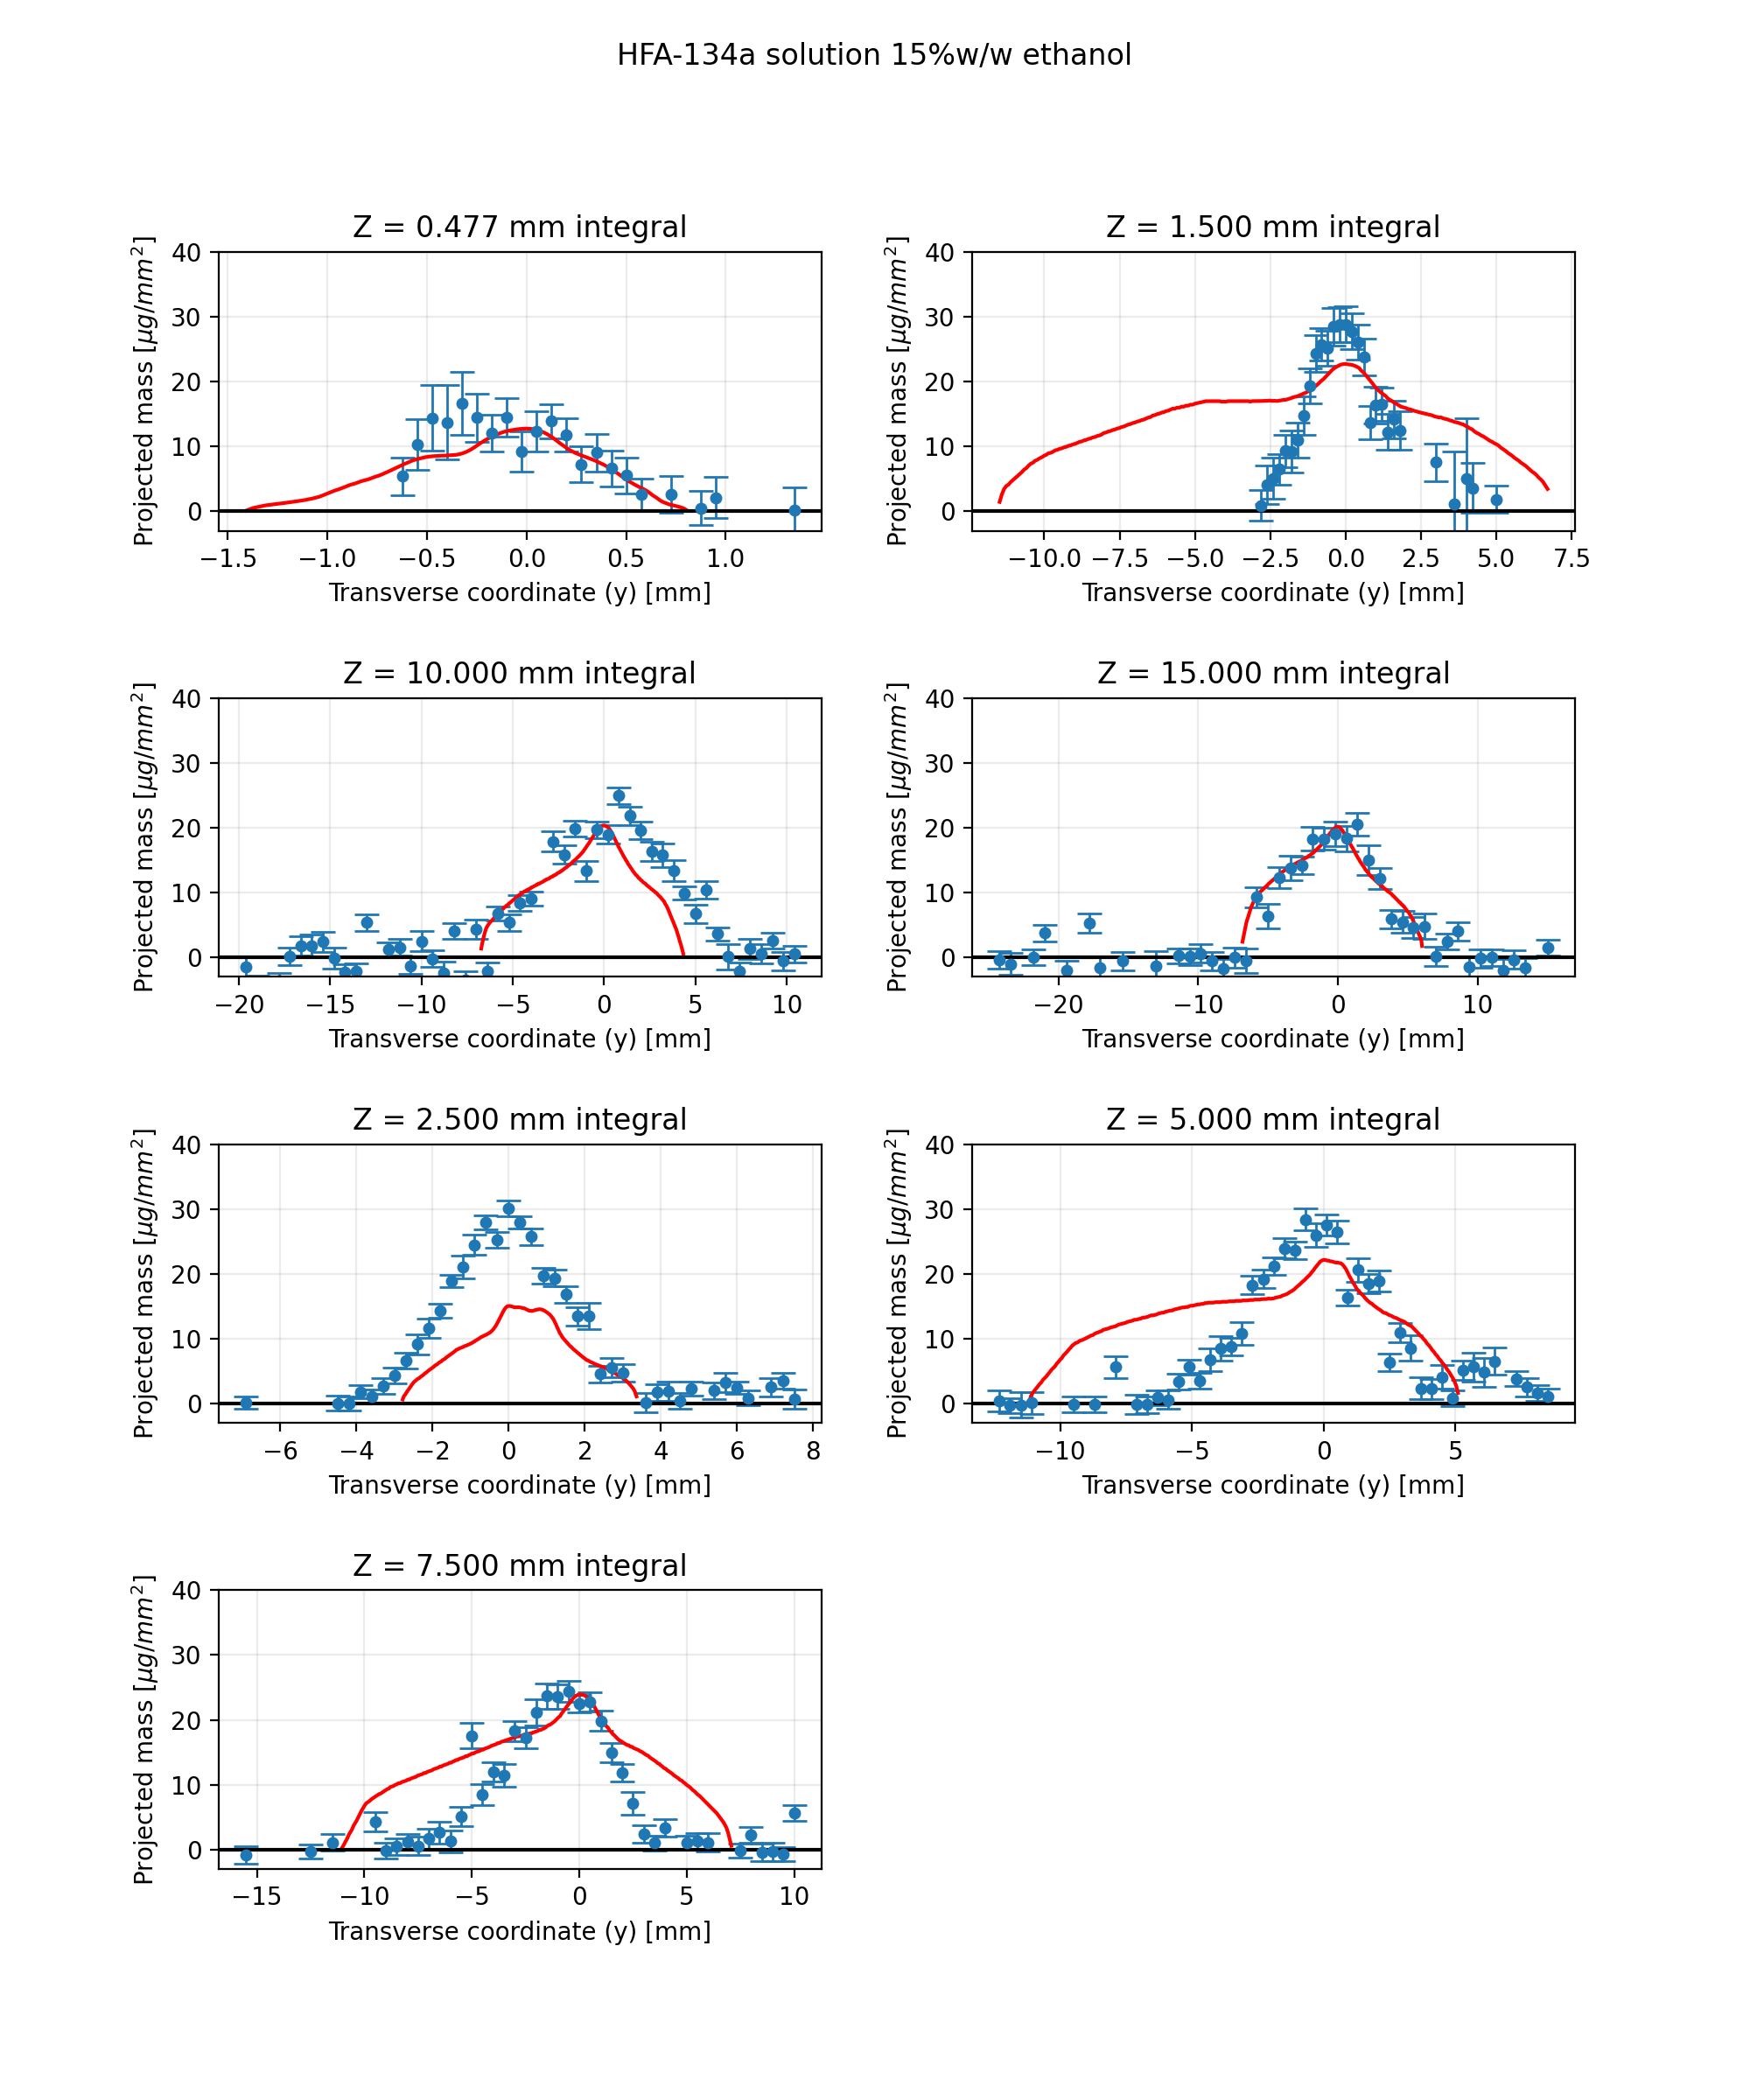

In [353]:
# Seperate plots for each Z position.
z_offset=[0.1, -5, -0.5, -0.5, 0,0,0] # z-offset between OF and X-ray, in mm.
recenter=True
fig=plt.figure(figsize=(10,12)); j=1
for xray in xray_profiles.values():
    ax=fig.add_subplot(4,2,j)
    plt.grid(alpha=.25)
    
    # Filter out points with very low signal level or outlier high signal level.
    #(np.abs(xray[1])>1e-2) & (np.abs(xray[2])>1e-2) 
    flt = (xray[2]>1e-5) & (xray[2]<40) & (xray[3]<20)
    
    # Subtract background  level in case not done in the source data file.
    if np.any(np.abs(xray[1][flt])>10):
        xray_bkgnd = np.nanmean(xray[2][flt][np.abs(xray[1][flt])>10])
    else:
        xray_bkgnd = 0
    
    # plot xray data
    ax.errorbar(xray[1][flt],xray[2][flt]*(xray[2][flt]>=0) - xray_bkgnd,yerr=xray[3][flt]/2.,\
                capsize=5,lw=1,ls='None',marker='o',ms=4,label='X-ray Experiment')
    
    # Find best matching integral from OF
    matching_of = np.where(np.abs(-zp*1e3-xray[0]+z_offset[j-1])<1e-4)[0]
    if len(matching_of)>=1 : i=matching_of[0]
    if recenter:
        maxi = np.where(integrals[i][1] == np.nanmax(integrals[i][1]))[0][0]
        x0 = integrals[i][0][maxi]
    else:        x0=0  
    y_ = (integrals[i][0]-x0)*1e3
    x_ = integrals[i][1]*1e3
    x_[x_==0]=np.nan
    ax.plot(y_, x_,label='Simulation',c='r')
    plt.axhline(0,c='k')
    plt.title('Z = %.3f mm integral' % (xray[0])) #plt.title('Z = %.3f mm (%i)' % (xray[0],i))
    plt.xlabel('Transverse coordinate (y) [mm]')
    plt.ylabel('Projected mass '+integratedUnits)
    #plt.xlim(y_.min()*1.5,y_.max()*1.5)
    #plt.ylim(-np.nanmax(x_)*0.05,np.nanmax(x_)*2)
    plt.ylim(-3,40)
    j+=1
plt.suptitle(description_string)
plt.subplots_adjust(wspace=.25,hspace=.6)
plt.savefig('Xray_Validate_Slices.pdf')